In [1]:
# copy from mnist of exmaple in chainer v4.0
from __future__ import print_function

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


import os
import numpy as np

In [2]:
train, test = chainer.datasets.get_mnist(ndim=3)

TWO_CLASS = False
if TWO_CLASS:
    index_0and1 = np.logical_or(train._datasets[1] == 0, train._datasets[1] == 1)

    datas = train[index_0and1]

    print(len(datas[1]), len(train._datasets[1]))

    train._datasets = datas
    train._length = len(datas[1])

    index_0and1 = np.logical_or(test._datasets[1] == 0, test._datasets[1] == 1)

    datas = test[index_0and1]

    print(len(datas[1]), len(test._datasets[1]))

    test._datasets = datas
    test._length = len(datas[1])

    print(test[0][0].shape)

In [3]:
train[:2], test[:2]

([(array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.

In [4]:
xs = [1, 2, 3]
len(xs), 2 > len(xs), 3 > len(xs)

(3, False, False)

In [5]:
# Network definition
BATCH_SIZE = 100
from chainer import ChainList, Chain
class SepLink(ChainList):
    def __init__(self, n_separate, link=L.Linear, **kwargs):
        """
            n_separate: 共用変数込みの分割サイズ
            共用, 特定クラス１, 特定クラス２, ...の順番
        """
        super(SepLink, self).__init__()
        self.n_separate = n_separate
        with self.init_scope():
            for i in range(self.n_separate):
                self.add_link(link(**kwargs))
    
    def __call__(self, xs):
        """
            xs: list of variables. eg. [common, specific class 1, specific class 2, ...]
        """
        assert len(xs) > 0
        common_x = xs[0]
        common_y = self[0](common_x)
        ys = [common_y]
        for i in range(1, self.n_separate):
            if i > len(xs) -1:
                x = common_x
            else:
                x = F.concat((common_x, xs[i]), axis=1)
            y = self[i](x)
            ys.append(y)
#         if self.input_sep_flag:
#             act_var = []
#             for i in range(self.n_separate):
#                 var = F.expand_dims(x.reshape(BATCH_SIZE, self.n_separate, -1)[:, i, :], 1)
#                 act_var.append(self[i](var))
#         else:
#             act_var = []
#             for i in range(self.n_separate):
#                 act_var.append(self[i](x))
#         res = F.concat(act_var, axis=1)
        return ys

class SepCLF(ChainList):
    def __init__(self, n_specific=2):
        super(SepCLF, self).__init__()
        self.n_specific = n_specific
        with self.init_scope():
            for i in range(self.n_specific):
                self.add_link(L.Linear(None, 1))
    
    def __call__(self, xs):
        assert 1 < len(xs)
        ys = []
        # 共用の結果は抜く
        for i, x in enumerate(xs[1:]):
            h = F.concat([xs[0], x], axis=1)
            ys.append(self[i](h))
        return ys

class SepConv(Chain):
    def __init__(self, in_channels, out_channels, n_specific=2):
        super(SepConv, self).__init__()
        with self.init_scope():
            self.conv1 = SepLink(n_separate=n_specific+1, link=L.Convolution2D,
                                in_channels=in_channels, out_channels=out_channels, ksize=3, stride=1)
#             self.l2 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
#             self.l3 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
            self.out = SepCLF(n_specific)
    def __call__(self, x):
        if not isinstance(x, list):
            x = [x]
#         print('x', len(x), list(map(lambda x:x.shape, x)))
        h1 = list(map(F.relu, self.conv1(x)))
#         print('h1', len(h1), list(map(lambda x:x.shape, h1)))
#         h2 = list(map(F.relu, self.l2(h1)))
#         print('h2', len(h2), list(map(lambda x:x.shape, h2)))
        _h = list(map(lambda x:F.mean(x, axis=(2, 3)), h1))
        outs = self.out(_h)
#         print('outs', len(outs), list(map(lambda x:x.shape, outs)))
        out = F.concat(outs, axis=1)
#         print('out', out.shape)
        return out

class Conv(Chain):
    def __init__(self, in_channels, out_channels, n_specific=2):
        super(Conv, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, out_channels, ksize=3, stride=1)
#             self.l2 = L.Linear(None, out_size)
            self.out = L.Linear(None, n_specific)
    
    def __call__(self, x):
        h1 = F.relu(self.conv1(x))
#         h2 = F.relu(self.l2(h1))
        out = self.out(F.mean(h1, axis=(2, 3)))
        return out

In [6]:
def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
    args_batchsize = BATCH_SIZE
    args_epoch = 50
    args_frequency = -1
    args_gpu = 0
    args_out = 'conv_result_all_class'
    args_unit = 4
    vanilla_train = True
    
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    print('GPU: {}'.format(args_gpu))
    print('# unit: {}'.format(args_unit))
    print('# Minibatch-size: {}'.format(args_batchsize))
    print('# epoch: {}'.format(args_epoch))
    print('')

    # Set up a neural network to train
    # Classifier reports softmax cross entropy loss and accuracy at every
    # iteration, which will be used by the PrintReport extension below.
    in_size = None
    args_unit
    n_specific = 10
#     model = L.Classifier(SepMLP(in_size, out_size))
    model = L.Classifier(Conv(None, out_channels=int(args_unit*(n_specific+1)), n_specific=n_specific))
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    if vanilla_train:
        print('training vanilla')
        chainer.serializers.save_npz(args_out +'/vanilla-base.model', model)
        trainer.run()
        chainer.serializers.save_npz(args_out +'/vanilla.model', model)

    args_out = 'sep_'+ args_out
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    model = L.Classifier(SepConv(None, out_channels=args_unit, n_specific=n_specific))
    print(model.predictor.conv1.n_separate)
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    print('training two separated model')
    chainer.serializers.save_npz(args_out +'/sep-base.model', model)
    trainer.run()
    chainer.serializers.save_npz(args_out +'/sep.model', model)

In [7]:
main()

GPU: 0
# unit: 4
# Minibatch-size: 100
# epoch: 50

training vanilla
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [..................................................]  0.33%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  0.67%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 50 epochs
    254.43 iters/sec. Estimated time to finish: 0:01:57.124766.
     total [..................................................]  1.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 50 epochs
    259.65 iters/sec. Estimated time to finish: 0:01:54.383589.
     total [..................................................]  1.33%
this epoch [##########################

     total [#####.............................................] 10.67%
this epoch [################..................................] 33.33%
      3200 iter, 5 epoch / 50 epochs
    234.46 iters/sec. Estimated time to finish: 0:01:54.305998.
     total [#####.............................................] 11.00%
this epoch [#########################.........................] 50.00%
      3300 iter, 5 epoch / 50 epochs
    235.75 iters/sec. Estimated time to finish: 0:01:53.255700.
     total [#####.............................................] 11.33%
this epoch [#################################.................] 66.67%
      3400 iter, 5 epoch / 50 epochs
       237 iters/sec. Estimated time to finish: 0:01:52.238420.
     total [#####.............................................] 11.67%
this epoch [#########################################.........] 83.33%
      3500 iter, 5 epoch / 50 epochs
    238.17 iters/sec. Estimated time to finish: 0:01:51.265180.
6           1.62824     1.59

     total [##########........................................] 21.00%
this epoch [#########################.........................] 50.00%
      6300 iter, 10 epoch / 50 epochs
    235.44 iters/sec. Estimated time to finish: 0:01:40.661808.
     total [##########........................................] 21.33%
this epoch [#################################.................] 66.67%
      6400 iter, 10 epoch / 50 epochs
    236.08 iters/sec. Estimated time to finish: 0:01:39.964597.
     total [##########........................................] 21.67%
this epoch [#########################################.........] 83.33%
      6500 iter, 10 epoch / 50 epochs
    236.72 iters/sec. Estimated time to finish: 0:01:39.274573.
11          1.4922      1.45787               0.454217       0.4727                    29.1986       
     total [###########.......................................] 22.00%
this epoch [..................................................]  0.00%
      6600 iter, 11 epoc

     total [###############...................................] 31.33%
this epoch [#################################.................] 66.67%
      9400 iter, 15 epoch / 50 epochs
     234.9 iters/sec. Estimated time to finish: 0:01:27.696412.
     total [###############...................................] 31.67%
this epoch [#########################################.........] 83.33%
      9500 iter, 15 epoch / 50 epochs
    235.32 iters/sec. Estimated time to finish: 0:01:27.113901.
16          1.42735     1.391                 0.474917       0.4931                    42.1088       
     total [################..................................] 32.00%
this epoch [..................................................]  0.00%
      9600 iter, 16 epoch / 50 epochs
    233.12 iters/sec. Estimated time to finish: 0:01:27.509734.
     total [################..................................] 32.33%
this epoch [########..........................................] 16.67%
      9700 iter, 16 epoc

     total [####################..............................] 41.67%
this epoch [#########################################.........] 83.33%
     12500 iter, 20 epoch / 50 epochs
    235.16 iters/sec. Estimated time to finish: 0:01:14.418143.
21          1.38713     1.34994               0.490017       0.5047                    54.9813       
     total [#####################.............................] 42.00%
this epoch [..................................................]  0.00%
     12600 iter, 21 epoch / 50 epochs
     232.7 iters/sec. Estimated time to finish: 0:01:14.773818.
     total [#####################.............................] 42.33%
this epoch [########..........................................] 16.67%
     12700 iter, 21 epoch / 50 epochs
    232.67 iters/sec. Estimated time to finish: 0:01:14.354270.
     total [#####################.............................] 42.67%
this epoch [################..................................] 33.33%
     12800 iter, 21 epoc

26          1.35454     1.31848               0.501583       0.5155                    67.8075       
     total [##########################........................] 52.00%
this epoch [..................................................]  0.00%
     15600 iter, 26 epoch / 50 epochs
    232.69 iters/sec. Estimated time to finish: 0:01:01.885654.
     total [##########################........................] 52.33%
this epoch [########..........................................] 16.67%
     15700 iter, 26 epoch / 50 epochs
    232.63 iters/sec. Estimated time to finish: 0:01:01.470448.
     total [##########################........................] 52.67%
this epoch [################..................................] 33.33%
     15800 iter, 26 epoch / 50 epochs
    232.62 iters/sec. Estimated time to finish: 0:01:01.044415.
     total [##########################........................] 53.00%
this epoch [#########################.........................] 50.00%
     15900 iter, 26 epoc

     total [###############################...................] 62.33%
this epoch [########..........................................] 16.67%
     18700 iter, 31 epoch / 50 epochs
    232.55 iters/sec. Estimated time to finish: 0:00:48.592216.
     total [###############################...................] 62.67%
this epoch [################..................................] 33.33%
     18800 iter, 31 epoch / 50 epochs
    232.55 iters/sec. Estimated time to finish: 0:00:48.161137.
     total [###############################...................] 63.00%
this epoch [#########################.........................] 50.00%
     18900 iter, 31 epoch / 50 epochs
    232.55 iters/sec. Estimated time to finish: 0:00:47.731163.
     total [###############################...................] 63.33%
this epoch [#################################.................] 66.67%
     19000 iter, 31 epoch / 50 epochs
    235.01 iters/sec. Estimated time to finish: 0:00:46.806699.
     total [############

     total [####################################..............] 72.67%
this epoch [################..................................] 33.33%
     21800 iter, 36 epoch / 50 epochs
    232.88 iters/sec. Estimated time to finish: 0:00:35.210653.
     total [####################################..............] 73.00%
this epoch [#########################.........................] 50.00%
     21900 iter, 36 epoch / 50 epochs
    232.95 iters/sec. Estimated time to finish: 0:00:34.771887.
     total [####################################..............] 73.33%
this epoch [#################################.................] 66.67%
     22000 iter, 36 epoch / 50 epochs
    235.32 iters/sec. Estimated time to finish: 0:00:33.996617.
     total [####################################..............] 73.67%
this epoch [#########################################.........] 83.33%
     22100 iter, 36 epoch / 50 epochs
    235.33 iters/sec. Estimated time to finish: 0:00:33.570002.
37          1.28566     

     total [#########################################.........] 83.00%
this epoch [#########################.........................] 50.00%
     24900 iter, 41 epoch / 50 epochs
    232.27 iters/sec. Estimated time to finish: 0:00:21.956982.
     total [#########################################.........] 83.33%
this epoch [#################################.................] 66.67%
     25000 iter, 41 epoch / 50 epochs
    234.58 iters/sec. Estimated time to finish: 0:00:21.314820.
     total [#########################################.........] 83.67%
this epoch [#########################################.........] 83.33%
     25100 iter, 41 epoch / 50 epochs
    234.64 iters/sec. Estimated time to finish: 0:00:20.882623.
42          1.25494     1.21379               0.54765        0.5638                    109.001       
     total [##########################################........] 84.00%
this epoch [..................................................]  0.00%
     25200 iter, 42 epoc

     total [##############################################....] 93.33%
this epoch [#################################.................] 66.67%
     28000 iter, 46 epoch / 50 epochs
     234.6 iters/sec. Estimated time to finish: 0:00:08.525079.
     total [##############################################....] 93.67%
this epoch [#########################################.........] 83.33%
     28100 iter, 46 epoch / 50 epochs
    234.62 iters/sec. Estimated time to finish: 0:00:08.098215.
47          1.22523     1.1861                0.563616       0.5803                    121.88        
     total [###############################################...] 94.00%
this epoch [..................................................]  0.00%
     28200 iter, 47 epoch / 50 epochs
    232.19 iters/sec. Estimated time to finish: 0:00:07.752170.
     total [###############################################...] 94.33%
this epoch [########..........................................] 16.67%
     28300 iter, 47 epoc

     total [#.................................................]  3.67%
this epoch [#########################################.........] 83.33%
      1100 iter, 1 epoch / 50 epochs
    41.356 iters/sec. Estimated time to finish: 0:11:38.815424.
2           2.16732     2.11328               0.236967       0.2467                    29.9477       
     total [##................................................]  4.00%
this epoch [..................................................]  0.00%
      1200 iter, 2 epoch / 50 epochs
    39.924 iters/sec. Estimated time to finish: 0:12:01.375725.
     total [##................................................]  4.33%
this epoch [########..........................................] 16.67%
      1300 iter, 2 epoch / 50 epochs
     40.18 iters/sec. Estimated time to finish: 0:11:54.278310.
     total [##................................................]  4.67%
this epoch [################..................................] 33.33%
      1400 iter, 2 epoch / 

7           1.86881     1.84938               0.329733       0.3257                    104.605       
     total [#######...........................................] 14.00%
this epoch [..................................................]  0.00%
      4200 iter, 7 epoch / 50 epochs
    40.119 iters/sec. Estimated time to finish: 0:10:43.088777.
     total [#######...........................................] 14.33%
this epoch [########..........................................] 16.67%
      4300 iter, 7 epoch / 50 epochs
    40.134 iters/sec. Estimated time to finish: 0:10:40.359867.
     total [#######...........................................] 14.67%
this epoch [################..................................] 33.33%
      4400 iter, 7 epoch / 50 epochs
    40.199 iters/sec. Estimated time to finish: 0:10:36.827847.
     total [#######...........................................] 15.00%
this epoch [#########################.........................] 50.00%
      4500 iter, 7 epoch / 

     total [############......................................] 24.33%
this epoch [########..........................................] 16.67%
      7300 iter, 12 epoch / 50 epochs
    40.134 iters/sec. Estimated time to finish: 0:09:25.604069.
     total [############......................................] 24.67%
this epoch [################..................................] 33.33%
      7400 iter, 12 epoch / 50 epochs
    40.173 iters/sec. Estimated time to finish: 0:09:22.566062.
     total [############......................................] 25.00%
this epoch [#########################.........................] 50.00%
      7500 iter, 12 epoch / 50 epochs
     40.21 iters/sec. Estimated time to finish: 0:09:19.568087.
     total [############......................................] 25.33%
this epoch [#################################.................] 66.67%
      7600 iter, 12 epoch / 50 epochs
    40.246 iters/sec. Estimated time to finish: 0:09:16.580923.
     total [############

     total [#################.................................] 34.67%
this epoch [################..................................] 33.33%
     10400 iter, 17 epoch / 50 epochs
    40.075 iters/sec. Estimated time to finish: 0:08:09.081270.
     total [#################.................................] 35.00%
this epoch [#########################.........................] 50.00%
     10500 iter, 17 epoch / 50 epochs
    40.073 iters/sec. Estimated time to finish: 0:08:06.615670.
     total [#################.................................] 35.33%
this epoch [#################################.................] 66.67%
     10600 iter, 17 epoch / 50 epochs
    40.228 iters/sec. Estimated time to finish: 0:08:02.256175.
     total [#################.................................] 35.67%
this epoch [#########################################.........] 83.33%
     10700 iter, 17 epoch / 50 epochs
     40.23 iters/sec. Estimated time to finish: 0:07:59.736452.
18          1.62057     

     total [######################............................] 45.00%
this epoch [#########################.........................] 50.00%
     13500 iter, 22 epoch / 50 epochs
    40.037 iters/sec. Estimated time to finish: 0:06:52.116938.
     total [######################............................] 45.33%
this epoch [#################################.................] 66.67%
     13600 iter, 22 epoch / 50 epochs
    40.203 iters/sec. Estimated time to finish: 0:06:47.931789.
     total [######################............................] 45.67%
this epoch [#########################################.........] 83.33%
     13700 iter, 22 epoch / 50 epochs
    40.202 iters/sec. Estimated time to finish: 0:06:45.448137.
23          1.56116     1.53835               0.438267       0.4473                    344.104       
     total [#######################...........................] 46.00%
this epoch [..................................................]  0.00%
     13800 iter, 23 epoc

     total [###########################.......................] 55.33%
this epoch [#################################.................] 66.67%
     16600 iter, 27 epoch / 50 epochs
    40.184 iters/sec. Estimated time to finish: 0:05:33.465846.
     total [###########################.......................] 55.67%
this epoch [#########################################.........] 83.33%
     16700 iter, 27 epoch / 50 epochs
    40.184 iters/sec. Estimated time to finish: 0:05:30.978604.
28          1.51449     1.48914               0.458633       0.4644                    419.087       
     total [############################......................] 56.00%
this epoch [..................................................]  0.00%
     16800 iter, 28 epoch / 50 epochs
    40.018 iters/sec. Estimated time to finish: 0:05:29.850216.
     total [############################......................] 56.33%
this epoch [########..........................................] 16.67%
     16900 iter, 28 epoc

     total [################################..................] 65.67%
this epoch [#########################################.........] 83.33%
     19700 iter, 32 epoch / 50 epochs
    40.119 iters/sec. Estimated time to finish: 0:04:16.737495.
33          1.47498     1.44834               0.475633       0.481                     494.196       
     total [#################################.................] 66.00%
this epoch [..................................................]  0.00%
     19800 iter, 33 epoch / 50 epochs
    39.952 iters/sec. Estimated time to finish: 0:04:15.303694.
     total [#################################.................] 66.33%
this epoch [########..........................................] 16.67%
     19900 iter, 33 epoch / 50 epochs
     39.95 iters/sec. Estimated time to finish: 0:04:12.816628.
     total [#################################.................] 66.67%
this epoch [################..................................] 33.33%
     20000 iter, 33 epoc

38          1.44167     1.41613               0.49005        0.4839                    569.202       
     total [######################################............] 76.00%
this epoch [..................................................]  0.00%
     22800 iter, 38 epoch / 50 epochs
    39.937 iters/sec. Estimated time to finish: 0:03:00.282280.
     total [######################################............] 76.33%
this epoch [########..........................................] 16.67%
     22900 iter, 38 epoch / 50 epochs
    39.936 iters/sec. Estimated time to finish: 0:02:57.785019.
     total [######################################............] 76.67%
this epoch [################..................................] 33.33%
     23000 iter, 38 epoch / 50 epochs
    39.936 iters/sec. Estimated time to finish: 0:02:55.279830.
     total [######################################............] 77.00%
this epoch [#########################.........................] 50.00%
     23100 iter, 38 epoc

     total [###########################################.......] 86.33%
this epoch [########..........................................] 16.67%
     25900 iter, 43 epoch / 50 epochs
    39.934 iters/sec. Estimated time to finish: 0:01:42.669721.
     total [###########################################.......] 86.67%
this epoch [################..................................] 33.33%
     26000 iter, 43 epoch / 50 epochs
    39.934 iters/sec. Estimated time to finish: 0:01:40.166079.
     total [###########################################.......] 87.00%
this epoch [#########################.........................] 50.00%
     26100 iter, 43 epoch / 50 epochs
    39.933 iters/sec. Estimated time to finish: 0:01:37.664324.
     total [###########################################.......] 87.33%
this epoch [#################################.................] 66.67%
     26200 iter, 43 epoch / 50 epochs
    40.095 iters/sec. Estimated time to finish: 0:01:34.773990.
     total [############

     total [################################################..] 96.67%
this epoch [################..................................] 33.33%
     29000 iter, 48 epoch / 50 epochs
     39.92 iters/sec. Estimated time to finish: 0:00:25.050061.
     total [################################################..] 97.00%
this epoch [#########################.........................] 50.00%
     29100 iter, 48 epoch / 50 epochs
     39.92 iters/sec. Estimated time to finish: 0:00:22.544966.
     total [################################################..] 97.33%
this epoch [#################################.................] 66.67%
     29200 iter, 48 epoch / 50 epochs
    40.112 iters/sec. Estimated time to finish: 0:00:19.944325.
     total [################################################..] 97.67%
this epoch [#########################################.........] 83.33%
     29300 iter, 48 epoch / 50 epochs
    40.113 iters/sec. Estimated time to finish: 0:00:17.450824.
49          1.37983     

In [10]:
in_size = None
n_specific = 10
out_size = 4
vanilla_model = L.Classifier(Conv(in_size, int(out_size*(n_specific+1)), n_specific=n_specific))
sep_model = L.Classifier(SepConv(in_size, out_size, n_specific=n_specific))
chainer.serializers.load_npz('./conv_result_all_class/vanilla.model', vanilla_model)
chainer.serializers.load_npz('./sep_conv_result_all_class/sep.model', sep_model)

In [11]:
van_mlp = vanilla_model.predictor
print(van_mlp.conv1.W.shape)

sep_mlp = sep_model.predictor
for i in range(sep_mlp.conv1.n_separate):
    print(sep_mlp.conv1[i].W.shape)

(44, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

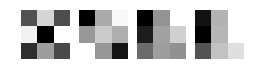

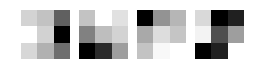

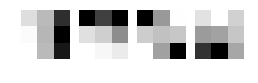

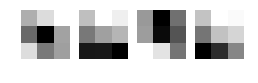

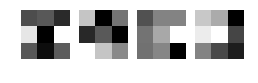

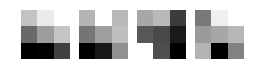

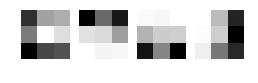

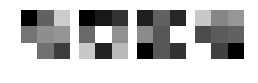

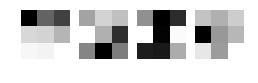

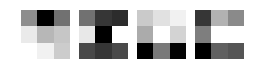

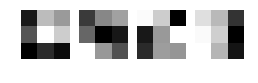

In [16]:
n_row = 1
n_col = out_size
for i in range(1, n_specific+2):
    plt.figure(figsize=(n_col, n_row))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(van_mlp.conv1.W.data[int((i-1)*out_size) + j].reshape(3, 3), cmap='gray')
        plt.axis('off')
    plt.show()

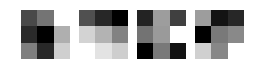

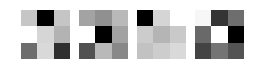

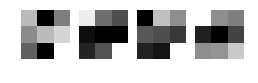

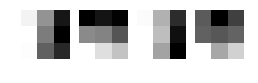

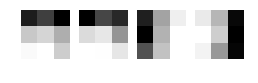

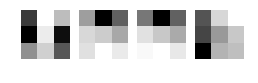

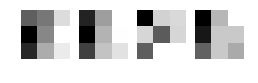

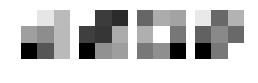

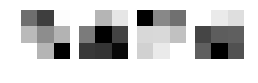

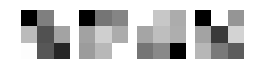

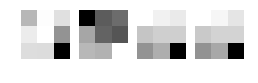

In [17]:
n_row = 1
n_col = out_size
for i in range(1, n_specific+2):
    plt.figure(figsize=(n_col, n_row))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(sep_mlp.conv1[i-1].W.data[j].reshape(3, 3), cmap='gray')
        plt.axis('off')
    plt.show()

(10, 44)


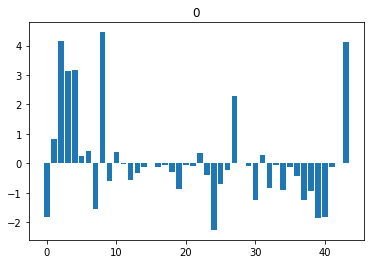

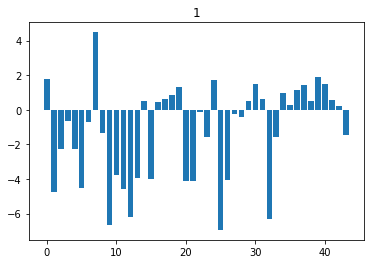

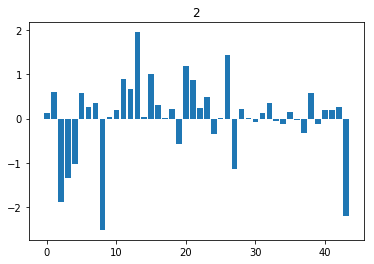

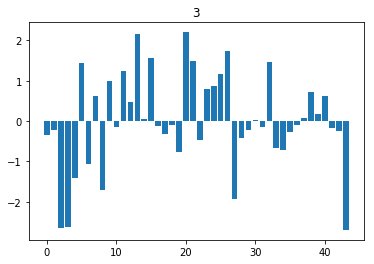

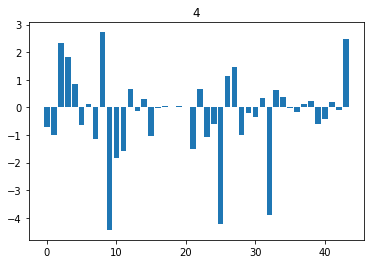

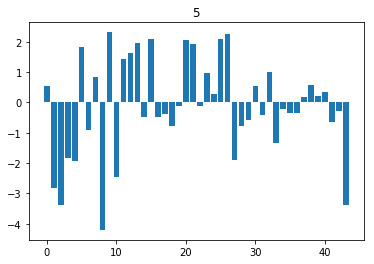

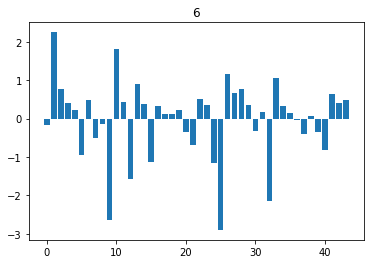

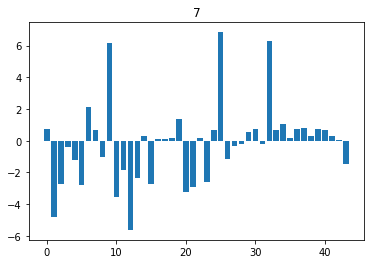

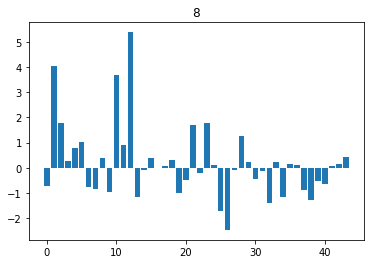

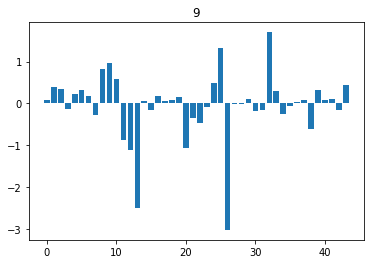

In [29]:
print(van_mlp.out.W.data.shape)
for i in range(n_specific):
    plt.title(i)
    plt.bar(np.arange(len(van_mlp.out.W.data[i])), van_mlp.out.W.data[i])
    plt.show()

[[ 0.31368482 -0.31719565 -3.2605412   0.05723159  0.39847386  1.3833655
   0.77577287  1.4929281 ]]


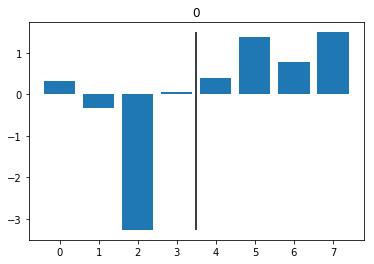

[[ -2.0587761 -13.385899    4.3986444  -3.150303   -2.340323    6.1035037
    6.8752      8.578358 ]]


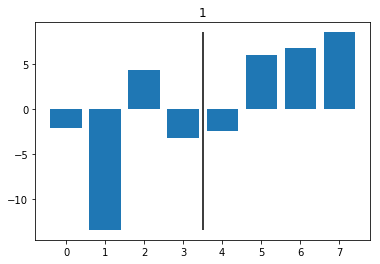

[[ 0.27920812  2.4157224  -1.0217985  -0.23110282 -4.245063    2.4472363
  -4.6484256   1.9677508 ]]


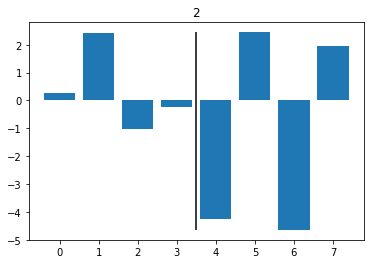

[[-0.47131202  3.7786384   0.16796926 -0.57428646  4.3322153   2.314935
  -6.3997517  -3.7952988 ]]


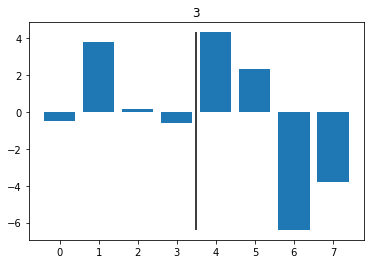

[[ 0.82812464 -3.7653563  -0.62636137 -0.64825785  5.5606346  -5.045
  -7.0291305   5.9600577 ]]


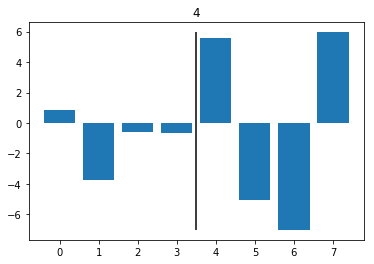

[[-0.15159287  6.4995437  -0.19535176 -0.33783934 -7.006692   -6.4502945
   0.13353054 -5.3534427 ]]


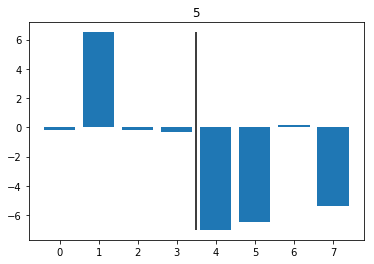

[[-0.25566462 -3.3505888  -0.58217615  0.20000377  0.51377213  4.8400273
   0.68170947  0.5817481 ]]


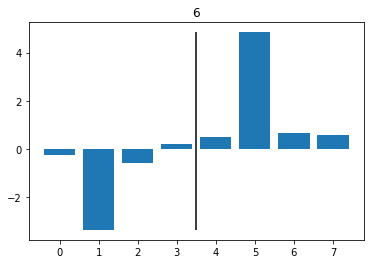

[[ -0.49892107  -1.887467     1.1218495    0.13642925 -12.816579
   -0.70510733   3.5320818   -0.9722344 ]]


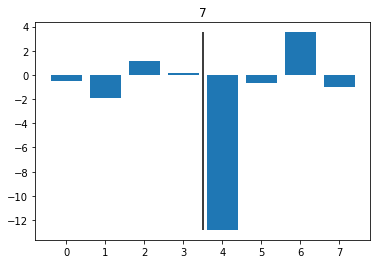

[[ 0.05087626  0.5134212  -1.5242575   0.27275518  6.4877877  -1.8104215
  -3.5003855   0.87783194]]


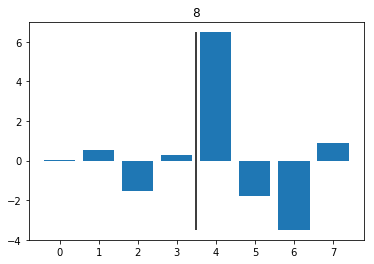

[[-0.48541164 -0.56410867  0.49381498  0.39976785  2.578191   -0.85726005
  -4.2933183  -4.3267927 ]]


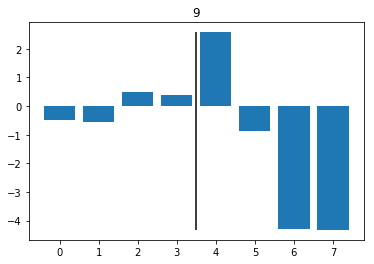

In [20]:
for i in range(n_specific):
    print(sep_mlp.out[i].W.data)
    plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
    ymax = sep_mlp.out[i].W.data.max()
    ymin = sep_mlp.out[i].W.data.min()
    plt.title(i)
    plt.vlines(out_size - .5 , ymin=ymin, ymax=ymax)
    plt.show()

In [21]:
test_data = test[:2]

In [22]:
test_image = np.asarray(list(map(lambda x: x[0], test_data)))
test_label = np.asarray(list(map(lambda x: x[1], test_data)))

In [23]:
van_feature_map = van_mlp.conv1(test_image)
van_outs = van_mlp(test_image)
sep_feature_map = sep_mlp.conv1([test_image])
sep_outs = sep_mlp(test_image)

In [24]:
van_feature_map.shape, van_outs.shape

((2, 44, 26, 26), (2, 10))

In [25]:
def norm(x):
    h = x.copy()
    h = h - h.min()
    h = h / h.max()
    return h

In [31]:
batch_size = 2

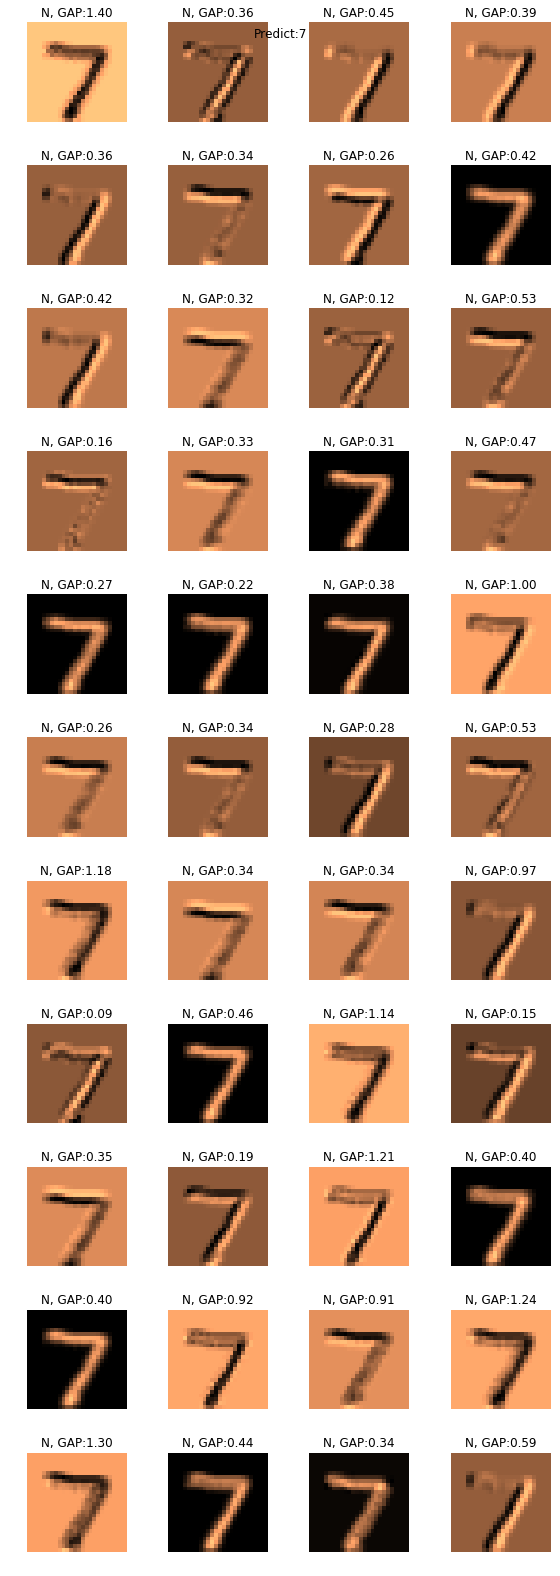

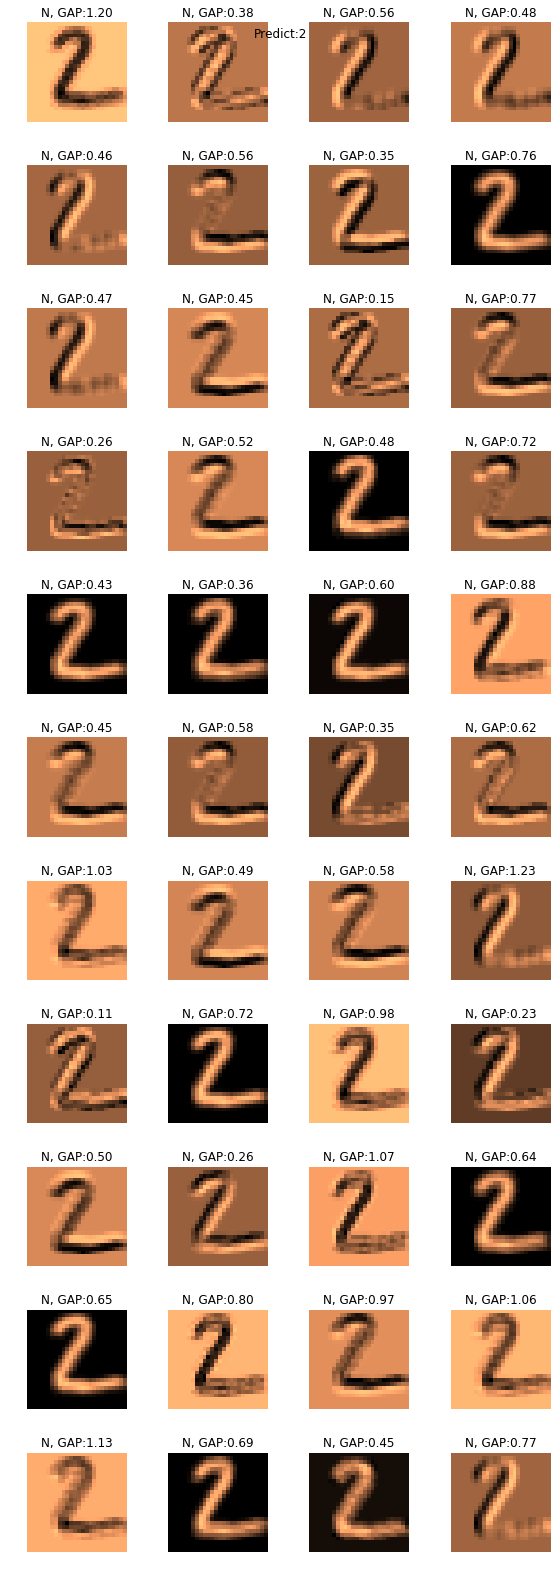

In [32]:
n_row = n_specific+1
n_col = out_size
for n in range(batch_size):
    plt.figure(figsize=(n_col*2, n_row*2))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(norm(van_feature_map.data)[n, j, :], cmap='copper')
        gap = np.mean(np.maximum(van_feature_map.data[n, j, :], 0))
        plt.title('{}, GAP:{:.2f}'.format('N', gap))
        plt.axis('off')
    
    plt.suptitle('Predict:{}'.format(np.argmax(van_outs.data[n])))
    plt.tight_layout()
    plt.show()

In [33]:
len(sep_feature_map), sep_feature_map[0].shape

(11, (2, 4, 26, 26))

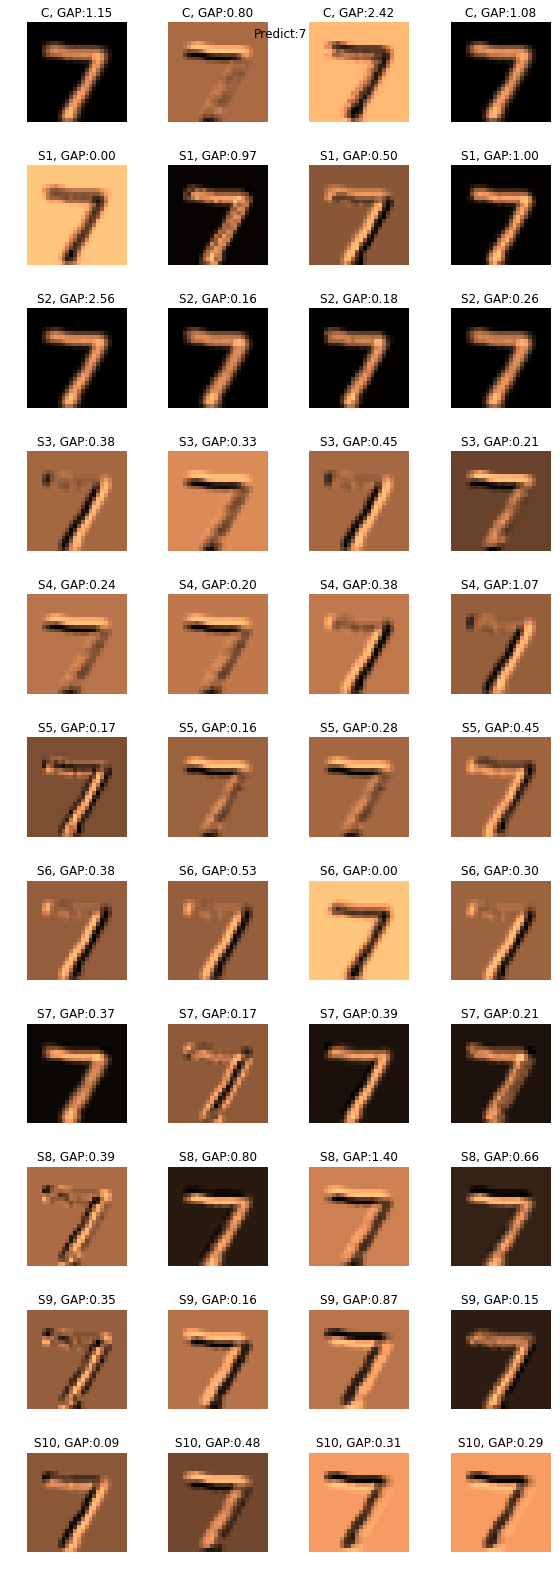

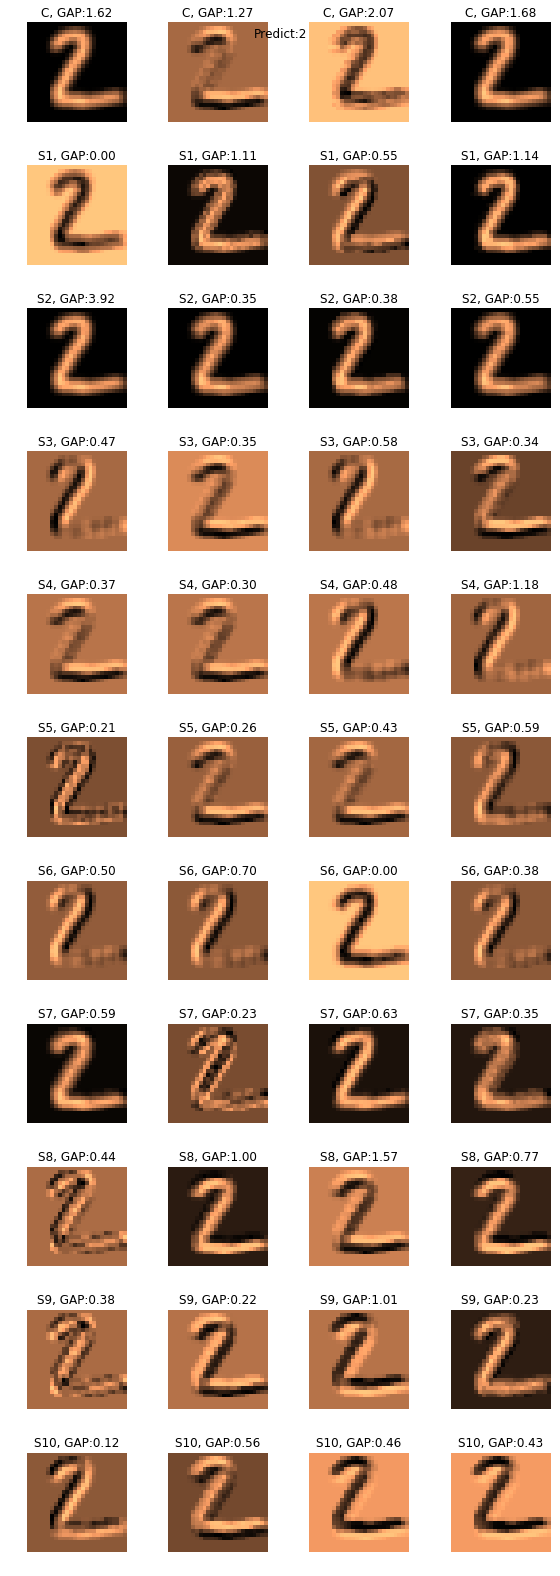

In [35]:
n_row = n_specific+1
n_col = out_size
for i in range(batch_size):
    plt.figure(figsize=(n_col*2, n_row*2))
    for n in range(n_row):
        if n == 0:
            sign = 'C'
        else:
            sign = 'S{}'.format(n)
        for j in range(n_col):
            plt.subplot(n_row, n_col, out_size*n + j+1)
            plt.imshow(norm(sep_feature_map[n].data)[i, j, :], cmap='copper')
            gap = np.mean(np.maximum(sep_feature_map[n].data[i, j, :], 0))
            plt.title('{}, GAP:{:.2f}'.format(sign, gap))
            plt.axis('off')
    plt.suptitle('Predict:{}'.format(np.argmax(van_outs.data[i])))
    plt.tight_layout()
    plt.show()

# 出力に使われている奴を見る

In [45]:
print(van_mlp.out.W.shape)
print(np.round(van_mlp.out.W.data, 2))
print('')
print(sep_mlp.out[0].W.shape)
for o in sep_mlp.out:
    print(np.round(o.W.data, 2))

(10, 44)
[[-1.84  0.83  4.15  3.14  3.18  0.23  0.43 -1.54  4.45 -0.62  0.4  -0.04
  -0.57 -0.35 -0.14 -0.   -0.13 -0.07 -0.3  -0.87 -0.06 -0.09  0.36 -0.41
  -2.26 -0.7  -0.24  2.3   0.02 -0.1  -1.26  0.27 -0.85 -0.07 -0.9  -0.11
  -0.44 -1.25 -0.94 -1.86 -1.82 -0.12 -0.01  4.11]
 [ 1.77 -4.77 -2.28 -0.66 -2.27 -4.51 -0.69  4.48 -1.33 -6.67 -3.79 -4.58
  -6.22 -3.92  0.51 -3.98  0.45  0.63  0.87  1.3  -4.1  -4.11 -0.14 -1.58
   1.7  -6.95 -4.09 -0.24 -0.44  0.48  1.48  0.65 -6.33 -1.55  0.97  0.28
   1.15  1.43  0.5   1.87  1.49  0.58  0.23 -1.43]
 [ 0.12  0.6  -1.88 -1.36 -1.02  0.59  0.27  0.34 -2.52  0.04  0.2   0.89
   0.66  1.96  0.03  1.    0.3   0.02  0.21 -0.57  1.2   0.87  0.24  0.49
  -0.36  0.    1.45 -1.15  0.22  0.01 -0.07  0.13  0.36 -0.06 -0.13  0.15
  -0.04 -0.33  0.59 -0.13  0.2   0.19  0.26 -2.2 ]
 [-0.35 -0.21 -2.64 -2.63 -1.41  1.45 -1.07  0.62 -1.72  0.99 -0.14  1.24
   0.48  2.17  0.04  1.57 -0.12 -0.31 -0.09 -0.77  2.2   1.48 -0.47  0.8
   0.88  1.18  1.74 -1.93

In [56]:
for n in range(batch_size):
    print(test_label[n])
    for i in range(n_specific):
        w_data = van_mlp.out.W.data[i]
        gap = np.mean(np.maximum(van_feature_map.data[n], 0), axis=(1, 2))
        z = w_data * gap
        print(np.round(z, 2))
        print(i, np.sum(z))
        
    print(z.shape)

7
[-2.58  0.3   1.87  1.22  1.14  0.08  0.11 -0.64  1.88 -0.19  0.05 -0.02
 -0.09 -0.11 -0.04 -0.   -0.03 -0.02 -0.11 -0.87 -0.02 -0.03  0.1  -0.22
 -2.68 -0.24 -0.08  2.23  0.   -0.05 -1.43  0.04 -0.3  -0.01 -1.09 -0.05
 -0.18 -1.16 -0.86 -2.3  -2.37 -0.05 -0.    2.41]
0 -6.400343
[ 2.49 -1.72 -1.03 -0.26 -0.81 -1.51 -0.18  1.87 -0.56 -2.11 -0.47 -2.41
 -1.02 -1.28  0.16 -1.89  0.12  0.14  0.33  1.3  -1.05 -1.42 -0.04 -0.83
  2.02 -2.37 -1.41 -0.24 -0.04  0.22  1.69  0.1  -2.21 -0.29  1.17  0.11
  0.46  1.32  0.46  2.31  1.95  0.25  0.08 -0.84]
1 -7.4390063
[ 0.17  0.21 -0.85 -0.53 -0.37  0.2   0.07  0.14 -1.07  0.01  0.02  0.47
  0.11  0.64  0.01  0.48  0.08  0.    0.08 -0.57  0.31  0.3   0.07  0.26
 -0.43  0.    0.5  -1.11  0.02  0.   -0.09  0.02  0.13 -0.01 -0.15  0.06
 -0.02 -0.3   0.54 -0.16  0.26  0.08  0.09 -1.29]
2 -1.5995095
[-0.49 -0.08 -1.19 -1.02 -0.5   0.48 -0.28  0.26 -0.72  0.31 -0.02  0.65
  0.08  0.71  0.01  0.75 -0.03 -0.07 -0.03 -0.77  0.57  0.51 -0.13  0.42
  1.04 

In [57]:
print(van_outs.data)
print(np.argmax(van_outs.data, axis=1))

[[ -6.7068167   -7.2221074   -1.4399158   -1.465978    -3.5021076
   -1.455562    -2.2321484    2.5056176   -3.5156107   -0.46636546]
 [ -3.446522   -18.005222    -0.17466705  -0.20950443  -4.744553
   -0.6843361   -2.1769066   -0.3216012   -2.2368274   -1.6718107 ]]
[7 2]


In [53]:
sep_feature_map[0].dtype

dtype('float32')

In [59]:
for n in range(batch_size):
    print(test_label[n])
    for i in range(n_specific):
        w_data = sep_mlp.out[i].W.data
        b_data = sep_mlp.out[i].b.data
        common_gap = np.mean(np.maximum(sep_feature_map[0].data[n], 0), axis=(1, 2))
        gap = np.mean(np.maximum(sep_feature_map[i+1].data[n], 0), axis=(1, 2))
#         print(common_gap.shape, gap.shape)
        gap = np.concatenate((common_gap, gap), axis=0)
#         print(gap.shape, w_data.shape)
        z = w_data[0] * gap
        print(np.round(z, 2), np.sum(z) + b_data)
    print(z.shape)

7
[ 0.36 -0.25 -7.87  0.06  0.    1.35  0.39  1.49] [-4.602556]
[ -2.37 -10.66  10.62  -3.41  -6.     1.     1.23   2.19] [-6.4190803]
[ 0.32  1.92 -2.47 -0.25 -1.62  0.8  -2.1   0.41] [-3.0124404]
[-0.54  3.01  0.41 -0.62  1.03  0.46 -2.46 -4.06] [-3.2203505]
[ 0.95 -3.   -1.51 -0.7   0.93 -0.82 -1.94  2.68] [-3.5154545]
[-0.17  5.18 -0.47 -0.37 -2.69 -3.44  0.   -1.58] [-3.1823666]
[-0.29 -2.67 -1.41  0.22  0.19  0.83  0.27  0.13] [-2.8993716]
[-0.57 -1.5   2.71  0.15 -4.96 -0.56  4.93 -0.64] [-0.62771726]
[ 0.06  0.41 -3.68  0.3   2.28 -0.29 -3.03  0.13] [-4.021347]
[-0.56 -0.45  1.19  0.43  0.24 -0.41 -1.35 -1.24] [-2.3878078]
(8,)
2
[ 0.51 -0.4  -6.75  0.1   0.    1.53  0.43  1.7 ] [-3.0129285]
[ -3.33 -17.     9.11  -5.28  -9.17   2.14   2.65   4.72] [-15.198694]
[ 0.45  3.07 -2.12 -0.39 -1.99  0.87 -2.68  0.66] [-2.147346]
[-0.76  4.8   0.35 -0.96  1.58  0.7  -3.09 -4.49] [-2.3222773]
[ 1.34 -4.78 -1.3  -1.09  1.15 -1.3  -3.04  3.54] [-5.5821424]
[-0.25  8.26 -0.4  -0.57 -3.47 -

In [51]:
print(sep_outs.data)
print(np.argmax(sep_outs.data, axis=1))

[[ -4.6025567  -6.4190803  -3.0124407  -3.22035    -3.5154548  -3.1823668
   -2.8993716  -0.627717   -4.0213466  -2.3878078]
 [ -3.0129285 -15.198692   -2.1473465  -2.3222773  -5.5821424  -2.669877
   -3.6339169  -2.3887715  -3.3964143  -4.043046 ]]
[7 2]
